In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
DEBUG = False

In [3]:
# Yould need to download the HSC images first
# for this go here
# https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr2/#bulk
# use last cells in GAMA09-coverage.ipynb to generate list for the website to batch download

In [64]:
#!/usr/bin/env python

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import spectrum
from astropy.io import ascii
from astropy.io import fits
from scipy import interpolate
import numpy
from matplotlib import pyplot as plot
import skimage.morphology
from scipy.optimize import least_squares
from astropy.stats import biweight_location
import numpy as np
from astropy.table import Table, Column
from matplotlib import transforms

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import os
import pickle

from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter

from astropy.io import ascii
from collections import OrderedDict
import os
from astropy.io import ascii

from scipy.interpolate import interp1d
params = {'legend.fontsize': 'x-small',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
plt.rcParams.update(params)

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import glob
from astropy.io import fits
from astropy import wcs
import sys, traceback
import argparse

In [65]:
def register_ds9staircase():
    # register color map
    from matplotlib.cm import register_cmap, cmap_d

    colors = []
    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*.3,kk*.3,kk*1)  )

    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*.3,kk*1,kk*.3)  )
    for ii in range(1,6):
        kk = ii/5.
        colors.append( (kk*1,kk*.3,kk*.3)  )
    colors = np.array(colors)
    xx = np.arange(len(colors), dtype=float)
    xx = xx/xx.max()

    ds9staircase = {'red': lambda v : np.interp(v, xx, colors[:,0]),
               'green': lambda v : np.interp(v, xx, colors[:,1]),
               'blue': lambda v : np.interp(v, xx, colors[:,2])}


    # Register all other colormaps
    register_cmap('ds9staircase', data=ds9staircase)

register_ds9staircase()

/tmp/ipykernel_7764/1772726260.py:26: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  register_cmap('ds9staircase', data=ds9staircase)


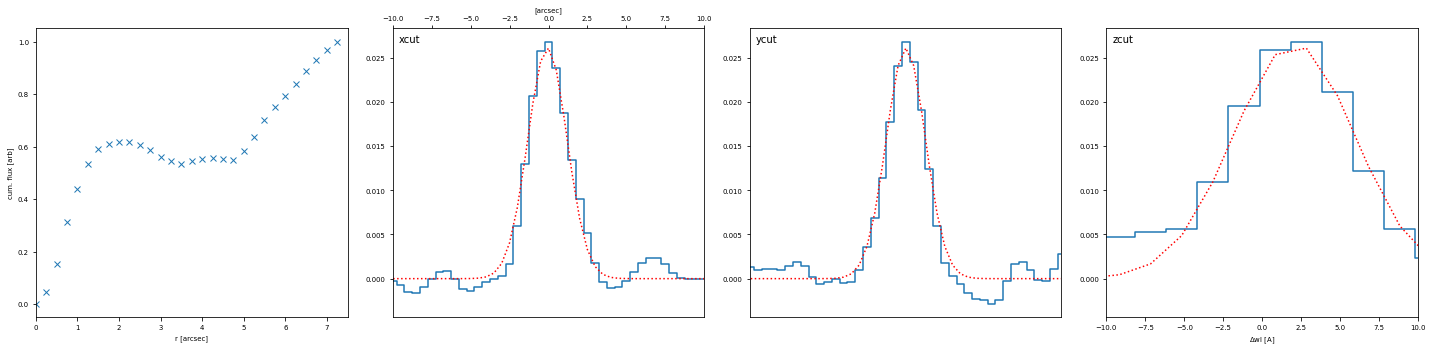

In [66]:




def identify_lines(wldetect, lineset, dlineset, flinelist):
    # detected line must be first line in list
    idetect = np.argmin( np.abs(lineset - wldetect) )
    _lineset = [lineset[idetect]]
    for l in lineset:
        if not l == _lineset[0]:
            _lineset.append(l)

    # http://classic.sdss.org/dr6/algorithms/linestable.html
    t = ascii.read(flinelist)

    for i,(l,dl) in enumerate(zip(_lineset,dlineset)):
        z = l/t["wl[A]"]-1.
        c = Column(z, name="z_{}".format(i))
        t.add_column(c)
        dz = (l+dl)/t["wl[A]"] - (l-dl)/t["wl[A]"]
        c = Column(dz, name="dz_{}".format(i))
        t.add_column(c)
    s = ""


    for r in t:
        if r["z_0"] < 0.:
            continue
        s += "If {:.2f}A is [{:12s}] @ restwl = {:.1f}A (z = {:.2f})\n".format(_lineset[0], r["species"], r["wl[A]"], r["z_0"])
        for i in range(1, len(_lineset)):
            if i == idetect:
                continue
            ii = np.abs( r["z_0"] - t["z_{}".format(i)] ) < (r["dz_0"] + t["dz_{}".format(i)])

            #print("{} lines match ".format(sum(ii)))
            for _r in t[ii]:

                obswl = (_r["wl[A]"] * (1. + r["z_0"]) )
                dA = _lineset[i] - obswl
                dv = dA/lineset[i] * 3e5
                #z = _r["wl[A]"]
                z = _lineset[i]/_r["wl[A]"] - 1.
                s += " {:.2f} could be [{:12s}] @ restwl {}, \n  wl_obs(z={:.2f})={:.2f}A, dA={:.2f}A, dv={:.2f}kms, z={:.2f}\n".format(_lineset[i], _r["species"], _r["wl[A]"],r["z_0"],obswl, dA, dv, z)
    return s


def draw_line(ax, wl, label):
    ymin,ymax = ax.get_ylim()
    ax.text(wl-5.,ymax, label, rotation=90., ha='right', size=10, va='top')
    ax.plot([wl]*2,[0.,.7], c='grey', lw=1., zorder=0)

    

def show_cogOrig(ax1, ax2, ax3, ax4, field, s, r, max_cog_radius = 7.5, max_cut_radius = 12., wl_extent=75.):
    x_com, y_com, z_com, wl_com = r["x_com"], r["y_com"],  r["z_com"], r["wl_com"]
    p = r["psfit_cnts"], r["psfit_xc"], r["psfit_yc"],r["psfit_zc"], r["psfit_sigxy"], r["psfit_sigz"]
    #print("x_com, y_com, z_com, wl_com : ", x_com, y_com, z_com, wl_com)
    hdu = s.hdu
    c = s.data

    pixelscale = 0.5
    rr = np.arange(0,max_cog_radius/pixelscale,.5)
    
    #old
    xx,yy = np.arange( c.shape[2] ), np.arange( c.shape[1] )
    XX,YY = np.meshgrid(xx,yy)
    
    # new
    #zz,yy,xx = [np.arange(sh, dtype=int) for sh in c.shape]
    #YY,ZZ,XX = np.meshgrid(yy, zz, xx)
                       

    ix = int( np.round(x_com) )
    iy = int( np.round(y_com) )
    iz = int( np.round(z_com) )
    dd = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. )

    cog = []
    for r in rr:
        ii = dd*pixelscale <= r
        flux = np.nansum(c[iz,ii])
        #print(flux)
        cog.append([r*pixelscale,flux])

    cog = np.array(cog)
    ax1.plot(cog[:,0], cog[:,1]/np.max(cog[:,1]),'x')
    ax1.set_xlabel("r [arcsec]")
    ax1.set_ylabel("cum. flux [arb]")
    
    fncog = "../specphot/cog_{}.txt".format(field)
    if os.path.exists(fncog):
        tcal = ascii.read(fncog, format="fixed_width")
        ax1.plot( tcal["r"], tcal["EE"] ,'-', c='b', alpha=0.5)
    
    ax1.set_xlim([0.,max_cog_radius])
    


    xx = (XX[iy,:]-x_com)*pixelscale
    yy = (YY[:,ix]-y_com)*pixelscale
    ii = np.abs(xx) <= max_cut_radius
    jj = np.abs(yy) <= max_cut_radius

    ax2.plot(xx[ii], c[iz,iy,ii],'-', label="xcut", drawstyle='steps-mid')

    ax2.set_xlabel("[arcsec]")

    ax2.xaxis.tick_top()
    ax2.xaxis.set_ticks_position('top') # THIS IS THE ONLY CHANGE
    ax2.xaxis.set_label_position('top')
    ax2.text(0.02,.98,"xcut",va="top", ha="left", transform=ax2.transAxes)

    ax3.plot(yy[jj], c[iz,jj,ix],'-', label="ycut", drawstyle='steps-mid')

    ax3.axes.get_xaxis().set_visible(False)
    ax3.text(0.02,.98,"ycut",va="top", ha="left", transform=ax3.transAxes)
    ax3.set_ylabel("")

    ww = s.grid()
    kk = np.abs(ww-wl_com) <=   wl_extent/2
    ax4.plot(ww[kk]-wl_com, c[kk,iy,ix],'-', label="wlcut", drawstyle='steps-mid')
    ax4.set_xlabel("$\Delta$wl [A]")
    ax4.set_ylabel("")
    ax4.text(0.02,.98,"zcut",va="top", ha="left", transform=ax4.transAxes)
    
    ax2.set_xlim([-10.,10.])
    ax3.set_xlim([-10.,10.])
    ax4.set_xlim([-10.,10.])





def show_cog(ax1, ax2, ax3, ax4, field, s, r, max_cog_radius = 7.5, max_cut_radius = 12., wl_extent=75.):
    #generic gaussian
    def gauss(sigma, xsq, norm=True):
        if norm:
            return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -xsq/(2. * sigma**2.))
        else:
            return np.exp( -xsq/(2. * sigma**2.))


    def gauss3D(xc, yc, zc, sigmaxy, sigmaz, XX, YY, ZZ):
        RRSQ = (XX - xc)**2 + (YY - yc)**2 
        g = gauss(sigmaxy, RRSQ, norm=True) * gauss(sigmaz, (ZZ - zc)**2., norm=True)
        return g


    def peval(p, XX, YY, ZZ):
        A, xc, yc, zc, sigmaxy, sigmaz = p
        g = gauss3D(xc, yc, zc, sigmaxy, sigmaz, XX, YY, ZZ) /  2.5066
        #g = g/np.sum(g)
        model = A * g
        #print("X", np.sum(g), np.sum(model))
        return model

    x_com, y_com, z_com, wl_com = r["x_com"], r["y_com"],  r["z_com"], r["wl_com"]
    
    p = r["psfit_cnts"], r["psfit_xc"], r["psfit_yc"],r["psfit_zc"], r["psfit_sigxy"], r["psfit_sigz"]
    
    #print("x_com, y_com, z_com, wl_com : ", x_com, y_com, z_com, wl_com)
    hdu = s.hdu
    c = s.data

    pixelscale = 0.5
    rr = np.arange(0,max_cog_radius/pixelscale,.5)
    
    #old
    #xx,yy = np.arange( c.shape[2] ), np.arange( c.shape[1] )
    #XX,YY = np.meshgrid(xx,yy)
    
    # new
    zz,yy,xx = [np.arange(sh, dtype=int) for sh in c.shape]
    YY,ZZ,XX = np.meshgrid(yy, zz, xx)
                       

    ix = int( np.round(x_com) )
    iy = int( np.round(y_com) )
    iz = int( np.round(z_com) )
    dd = np.sqrt( (XX[0]-x_com)**2. + (YY[0]-y_com)**2. )

    cog = []
    for r in rr:
        ii = dd*pixelscale <= r
        flux = np.nansum(c[iz,ii])
        #print(flux)
        cog.append([r*pixelscale,flux])

    cog = np.array(cog)
    ax1.plot(cog[:,0], cog[:,1]/np.max(cog[:,1]),'x')
    ax1.set_xlabel("r [arcsec]")
    ax1.set_ylabel("cum. flux [arb]")
    
    fncog = "../specphot/cog_{}.txt".format(field)
    if os.path.exists(fncog):
        tcal = ascii.read(fncog, format="fixed_width")
        ax1.plot( tcal["r"], tcal["EE"] ,'-', c='b', alpha=0.5)
    
    ax1.set_xlim([0.,max_cog_radius])
    


    xx = (XX[0, iy,:]-x_com)*pixelscale
    yy = (YY[0, :,ix]-y_com)*pixelscale
    ii = np.abs(xx) <= max_cut_radius
    jj = np.abs(yy) <= max_cut_radius

    ax2.plot(xx[ii], c[iz,iy,ii],'-', label="xcut", drawstyle='steps-mid')

    ax2.set_xlabel("[arcsec]")

    ax2.xaxis.tick_top()
    ax2.xaxis.set_ticks_position('top') # THIS IS THE ONLY CHANGE
    ax2.xaxis.set_label_position('top')
    ax2.text(0.02,.98,"xcut",va="top", ha="left", transform=ax2.transAxes)

    ax3.plot(yy[jj], c[iz,jj,ix],'-', label="ycut", drawstyle='steps-mid')

    ax3.axes.get_xaxis().set_visible(False)
    ax3.text(0.02,.98,"ycut",va="top", ha="left", transform=ax3.transAxes)
    ax3.set_ylabel("")

    ww = s.grid()
    kk = np.abs(ww-wl_com) <=   wl_extent/2
    ax4.plot(ww[kk]-wl_com, c[kk,iy,ix],'-', label="wlcut", drawstyle='steps-mid')
    ax4.set_xlabel("$\Delta$wl [A]")
    ax4.set_ylabel("")
    ax4.text(0.02,.98,"zcut",va="top", ha="left", transform=ax4.transAxes)
    
    ax2.set_xlim([-10.,10.])
    ax3.set_xlim([-10.,10.])
    ax4.set_xlim([-10.,10.])
    
    
    
    model = peval(p, XX, YY, ZZ)
    ax2.plot(xx[ii], model[iz,iy,ii],'-', label="xcut", linestyle=':', color='red')
    ax3.plot(yy[jj], model[iz,jj,ix],'-', label="ycut", linestyle=':', color='red')
    ax4.plot(ww[kk]-wl_com, model[kk,iy,ix],'-', label="wlcut", linestyle=':', color='red')
if DEBUG or True:

    params = {'legend.fontsize': 'x-small',
              'figure.figsize': (15, 5),
             'axes.labelsize': 'x-small',
             'axes.titlesize':'x-small',
             'xtick.labelsize':'x-small',
             'ytick.labelsize':'x-small'}
    plt.rcParams.update(params)

    # testcode
    IFU = "016"
    field = "gama09Efin"
    id = 471
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]
    s = spectrum.readSpectrum(fincube)
    f = plt.figure(figsize=[20,5])
    ax1 = plt.subplot(141)
    ax2 = plt.subplot(142)
    ax3 = plt.subplot(143, sharey=ax2)
    ax4 = plt.subplot(144, sharey=ax2)
    show_cog(ax1, ax2, ax3, ax4, field, s, r)
    
    f.tight_layout()

In [67]:
    
def query_simbad(ra,dec,radius):
    if not os.path.exists("../simbad_cache"):
        os.mkdir("../simbad_cache")
        
    fcache = "../simbad_cache/{:.6f}_{:.6f}_{:.6f}.pickle".format(ra,dec,radius)
    customSimbad = Simbad()

    customSimbad.get_votable_fields()

    if os.path.exists(fcache):
        print("Found SIMBAD cache file {} ...".format(fcache))
        return pickle.load( open( fcache, "rb" ) )
    else:
        print("Running SIMBAD query {} ...")
        
    # To set other fields
    customSimbad.add_votable_fields('mk', 'rot', 'bibcodelist(1800-2014)', 'z_value','pmra')
    customSimbad.get_votable_fields()
    customSimbad.add_votable_fields('ra(2;A;ICRS;J2017.5;2000)', 'dec(2;D;ICRS;2017.5;2000)')
    customSimbad.remove_votable_fields('coordinates')
    result = customSimbad.query_region(coord.SkyCoord(ra=ra, dec=dec,
                                        unit=(u.deg, u.deg), frame='fk5'),
                                        radius=radius * u.deg,
                                        epoch='J2000',
                                        equinox=2000)
    
    if type(result) == type(None):
        print("Simbad query returned None.")
        return []
    
    print("Found {} objects.".format(len(result)))
    if len(result) == 0:
        return []

    from astropy.coordinates import SkyCoord
    cc = [SkyCoord(r, a, unit=(u.hourangle, u.deg)) for r,a in
          zip(result["RA_2_A_ICRS_J2017_5_2000"], result["DEC_2_D_ICRS_2017_5_2000"])]

    aa = [c.ra.deg for c in cc]
    dd = [c.dec.deg for c in cc]

    simbad_catalog =  [[id,a,d,z] for id,a,d,z in zip(result["MAIN_ID"], aa,dd, result["Z_VALUE"])]

    pickle.dump( simbad_catalog, open( fcache, "wb" ) )
    

    cra  = [l[1] for l in simbad_catalog]
    cdec = [l[2] for l in simbad_catalog]
    cz   = [l[3] for l in simbad_catalog]

    photz_catalog = Table( [range(len(simbad_catalog)), cra, cdec, cz], names=["id", "ra","dec","z"] )
                    

    return photz_catalog


if DEBUG:
    ra,dec = 130.1797826, 2.3614049
    radius = 1./60 # HET has a 22 armin FoV, do r=12 to be save

    simbad_catalog = query_simbad(ra,dec,radius)
    print(simbad_catalog)

In [68]:
def query_hsc(ra,dec,radius, fncatalog = "../hsc_small.ecsv"):
    
    if not os.path.exists(fncatalog):
        print("ERROR: Could not find hsc catalog {}.".format())
        return
        
    t = Table.read(fncatalog, format='ascii.ecsv')
    ddsq = ((t['ra']-ra) * np.cos(t['dec']))**2. +  (t['dec'] - dec)**2.
    jj = ddsq < radius**2.
    
    t['photoz_best'].name = 'z'
    t['object_id'].name = 'id'
    t['g_cmodel_mag'].name = 'gmag'
    
    result = Table( [t['id'][jj], t['ra'][jj],t['dec'][jj],t['z'][jj],t['gmag'][jj]] )


    return result


if DEBUG:
    ra,dec = 130.1797826, 2.3614049
    radius = 5*1.4/3600. # HET has a 22 armin FoV, do r=12 to be save

    hsc_catalog = query_hsc(ra,dec,radius)
    print(hsc_catalog)

In [69]:
# simple continuum removal though spline interpolation
def confitSpl(wls, s, n = 10, kappaL=2.5, kappaU=2.5, output_fit=False, smooth=0., mask=None, PLOT=False, maxiter=15):
    if mask == None:
        mask_ = wls > -1 # use all
    else:
        mask_ = mask.copy()
    mask_ *= ~ np.isnan(s)
    l = len(wls)
    l = np.floor(l/n)
    dwl = (wls[-1]-wls[0])/n

    niter = 0
    nmasked = len(mask_[~mask_])
    while niter < maxiter:
        bwls = []
        bs   = []

        # put one point at the blue end, window only half the normal binsize
        wlstart = wls[0]
        wlstop  = wls[0] + dwl/2.
        ii = (wls >= wlstart) * (wls <= wlstop)
        if type(mask_) != type(None): ii *= mask_

        binned_wls = np.mean( wls[ii] )
        bwls.append( binned_wls )
        bs.append(    np.median(   s[ii] ) )
        # normal points, normal binsize
        for i in range(n-1):
                wlstart = wls[0]  + dwl/2. + dwl * i
                wlstop  = wls[0]  + dwl/2. + dwl * (i + 1)
                ii = (wls >= wlstart) * (wls <= wlstop)
                if type(mask_) != type(None): ii *= mask_
                binned_wls = np.mean( wls[ii] )
                bwls.append( binned_wls )
                bs.append(    np.median(   s[ii] ) )
        # put one point at the red end, window only half the normal binsize
        wlstart = wls[-1] - dwl/2.
        wlstop  = wls[-1]
        ii = (wls >= wlstart) * (wls <= wlstop)
        if type(mask_) != type(None): ii *= mask_
        binned_wls = np.mean( wls[ii] )
        bwls.append( binned_wls )
        bs.append(    np.median(   s[ii] ) )

        tck = interpolate.splrep(bwls,bs,s=smooth)
        c = interpolate.splev(wls,tck,der=0)

        res = s-c
        sigma = np.std(res[mask_])

        inliers  = ( res) <= kappaU*sigma
        inliers *= (-res) <= kappaL*sigma

        mask_ *= inliers
        nmasked_new = len(mask_[~mask_])
        if nmasked_new == nmasked:
            break
        nmasked = nmasked_new

        niter += 1
    if PLOT:
        f=plt.figure()
        plt.plot(wls,s)
        plt.plot(wls,c)
        plt.plot(wls[~mask_],s[~mask_],'r.')
        plt.ylim([-1.,1.])

    # filter lowest and highest 3 fourier channels
    sc = s-c

    if output_fit:
        return sc,c
    else:
        return sc
    
    

def line_detect(ww, csout, threshold):
    # line detection (everything above cetain threshold)
    jj = csout > threshold

    # labelling line detections
    label = skimage.morphology.label(jj)
    ll = np.unique( label )

    lineset = []
    dlineset = []

    for l in ll:
        if l == 0:
            continue
        ii = l == label
        f = np.sum( csout[ii] )
        wl_com = np.sum( ww[ii]*csout[ii] ) /np.sum(csout[ii] )
        #print("{} {:.2f}A {:.2f}".format(l, wl_com, f))
        lineset.append(wl_com)
        dlineset.append(2.)
    return lineset, dlineset, jj

def masked_biweight(cube_slice, mask):
    return biweight_location( cube_slice[mask] )



def masked_sum(cube_slice, mask):
    return np.sum( cube_slice[mask] )



def extract(r, s, outmap, method=masked_biweight):
    mask = np.sum( outmap == r['id'], axis=0) > 0

    sout = np.zeros( s.data.shape[0]  )
    N = np.sum(mask)
    for i in range(s.data.shape[0]):
        #sout[i] = np.sum( s.data[i][mask] )
        #sout[i] = biweight_location( s.data[i][mask] )*N # statistically stable mean times number of pixel
        sout[i] = method( s.data[i], mask )

    ww = s.grid()
    return ww,sout, mask



def nextract(r, s, outmap, method=masked_biweight, MAX_SAMPLES = 30):
    """
    Shifts the aperture corresponding to a detection around in the noise cube to
    sample the noise N times. The mask is shifted such as to not overlap
    wiht he previous location of the mask

    Original, actual mask
    xxxxxxxxxx
    xxx..xxxxx
    xx...xxxxx
    xxx..xxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 1
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 2
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx

    Sample 3
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 4
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx

    Sample 5
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 6
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    """

    mask = np.sum( outmap == r['id'], axis=0) > 0

    # determine masked, region size
    xx = np.arange(mask.shape[1])
    yy = np.arange(mask.shape[0])

    X,Y = np.meshgrid(xx,yy)
    minx,maxx = X[mask].min(), X[mask].max()
    miny,maxy = Y[mask].min(), Y[mask].max()
    sx = maxx - minx + 2
    sy = maxy - miny + 2
    nx,ny = mask.shape[1]//sx, mask.shape[0]//sy

    #f = plt.figure(figsize = [7,7])
    #plt.imshow(mask)

    all_sout = []
    count = 1
    print("Sampling noise in {} separate regions".format( min(nx * ny, MAX_SAMPLES)  ) )
    for i in range(nx):
        if count > MAX_SAMPLES:
            break
        
        for j in range(ny):
            print("Sampling noise column {} and row {}".format(i, j))
            _mask = mask < 0 # empty mask
            #print(sy*(j), sy*(j+1),sx*(i), sx*(i+1), miny, miny+sy, minx, minx+sx )

            m = mask[miny:miny+sy, minx:minx+sx]
            _mask[sy*(j):sy*(j)+m.shape[0],sx*(i):sx*(i)+m.shape[1]] = m
            #f = plt.figure(figsize = [7,7])
            #plt.imshow(_mask)

            sout = np.zeros( s.data.shape[0]  )
            for k in range(s.data.shape[0]):
                sout[k] = method( s.data[k], _mask )
            all_sout.append(sout)
            count += 1

    ww = s.grid()
    return ww, np.array(all_sout), mask


if DEBUG:
    IFU = '023'
    field = 'gama09E'
    id = 195
    foutmap = "../data/map{}_{}.fits.gz".format(field,IFU)
    fincube = "../data/sf{}_{}.fits.gz".format(field,IFU)
    fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field,IFU)

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    flinelist = "linelist.txt"

    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    ns = spectrum.readSpectrum(fnoisecube)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]

    ww,sout, mask = extract(r, s, outmap)
    ww,nsout, mask = nextract(r, ns, outmap)

    mm = np.std(nsout,axis=0)
    plt.plot(ww,sout)
    plt.fill_between(ww, 5.*mm, -5.*mm,alpha=0.3, edgecolor='black', facecolor='grey', label="5 - sigma")
    plt.fill_between(ww, mm, -mm,alpha=0.3, edgecolor='black', facecolor='grey', label="1 - sigma")
    plt.legend()
    plt.xlabel("wavelength [A]")
    plt.ylabel("flux")

In [70]:
def show_image(ax, r, hdu, w, title, width = 20./3600., AXLABELS=True, photz_catalog=[], vmin=-2.e-5,vmax=10.):
    ra,dec = r["ra_com"], r["dec_com"]
    cos_term = np.cos(np.deg2rad(dec))
    #cos_term=1.
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)
    x,y = w.wcs_world2pix(ra,dec,0)

    #print("show_image ", vmin, vmax)
    plt.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest')
    plt.plot([x],[y],'x',c='white', ms=15)
    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    ax.text(0.05,0.05,title,transform=ax.transAxes, color='white')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")

    
    plt.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest')
    xlim = plt.xlim()
    ylim = plt.ylim()    
    
    if len(photz_catalog) != 0.:
        xx,yy = w.wcs_world2pix(photz_catalog["ra"],photz_catalog["dec"],1)
        zz = photz_catalog["z"]
        zzmask = photz_catalog["z"].mask
        gg = photz_catalog["gmag"]
        ii = (xx >= xlim[0]) * (xx <= xlim[1]) * (yy >= ylim[0]) * (yy <= ylim[1])
        plt.plot(xx[ii],yy[ii],'o',c='None', ms=5, markeredgecolor='white')

        for x,y,z,zmask,gmag in zip(xx[ii],yy[ii],zz[ii],zzmask[ii],gg[ii]):
            if ~zmask:
                plt.text(x+2.,y+2., "z={:.3f}".format(z), color='white',fontsize=6)
            if ~np.isnan(gmag):
                plt.text(x+2.,y-2., "g={:.1f}".format(gmag), color='white',fontsize=6)

    if not AXLABELS:
        ra = ax.coords[0]
        dec = ax.coords[1]
        ra.set_ticks_visible(False)
        ra.set_ticklabel_visible(False)
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.axis('off')

if DEBUG:

    IFU = "023"
    field = "gama09E"
    id = 195

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    

    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]
    # testcode
    ra,dec = r["ra_com"], r["dec_com"]
    #print(ra,dec)

    #images = []
    #for f in image_catalog:
    #    w,shape,t,b = image_catalog[f]
    #    x,y = w.wcs_world2pix(ra,dec,0)
    #    #print(x,y)
    #    if x >= 0 and x <= shape[1] and y >= 0 and y <= shape[0]:
    #        images.append(f)

    width = 20./3600.
    

    filename = "../gbimages/hsc/{}_{}_HSC-G.fits".format(field, IFU)
    hdu = fits.open(filename)['IMAGE']
    w = wcs.WCS(hdu.header)
    #ax = plt.subplot(projection=wcs)
    f = plt.figure()
    ax = plt.subplot(111,projection=w)
    
    photz_catalog = query_hsc(r['ra_com'], r['dec_com'], 0.0014)
    show_image(ax, r, hdu, w, "", width = width, AXLABELS=True, vmin=-2.e-5,vmax=.1, photz_catalog=photz_catalog)
    
    
    f.tight_layout()

    

In [71]:
   
from scipy.optimize import least_squares

import numpy as np

#generic gaussian
def gauss(mu, sigma, x):
    return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

def peval(p,x):
    A,mu,sigma = p
    return A*gauss(mu, sigma, x)

def resid(p, x, y, yerr=[]):
    model = peval(p,x)
    if yerr==[]:
        return (y - model)
    else:
        return (y - model)/yerr

def fit_gaussians(lineset, ww, csout, wlwin, pp=[]):
    results = []

    for i,wlc in enumerate(lineset):
        if pp != []:
                p0 = pp[i]
        else:
            p0 = [2000.,wlc,10.]
        ii = (ww > wlc-wlwin/2.) * (ww < wlc+wlwin/2.)
        ii *= ~ np.isnan(csout)
        fit = least_squares(resid, p0, args=(ww[ii], csout[ii]))
        p = fit.x

        if False:
            f=plt.figure()

            plt.plot(ww[ii], csout[ii])
            plt.plot(ww[ii], peval(p,ww[ii]))

        results.append([p[0], p[1],p[2]])

    results = np.array(results)


    return results

def fit_peak( ww, csout_unsmoothed,  r, win ):

    ff = csout_unsmoothed
    #yerr = np.std(nsout,axis=0)
    ii = (ww > (r["wl_com"] - win/2.)) * (ww < (r["wl_com"] + win/2.))
    ii *= ~ np.isnan(csout_unsmoothed)

    dw = ww[1]-ww[0]

    A0 = np.sum(ff[ii]) * dw
    mu0    = r["wl_com"]
    sigma0 = r["dwl"]
    p0=[A0,mu0,sigma0]

    #fit = least_squares(resid, p0, args=(ww[ii],ff[ii],yerr[ii]))
    fit = least_squares(resid, p0, args=(ww[ii],ff[ii]))
    p = fit.x
    #print(fit.x)
    ii = (ww > (p[1] - win/2.)) * (ww < (p[1] + win/2.))
    ii *= ~ np.isnan(ff)
    # refit with better centroid
    fit = least_squares(resid, p0, args=(ww[ii],ff[ii]))
    p = fit.x
    #print(fit.x)

    if False:
        f = plt.figure()
        plt.plot(ww[ii],ff[ii])
        plt.errorbar(ww[ii],ff[ii],yerr[ii])
        plt.plot(ww[ii],peval(p,ww[ii]))
        #ax1.fill_between(ww, yerr, -yerr,alpha=0.2, edgecolor='black', facecolor='grey')
    return p

def add_line_indicatorsNew(ax, wldetect, flinelist, candidates = [["Lyα", 1215.24,"red",-20.,-.0025],["OII",3727.1,"green",+20.,-.005]]):
    ymin,ymax = ax.get_ylim()
    print("ymin,ymax = ", ymin,ymax)
    xmin,xmax = ax.get_xlim()
    width = 15.
    t = ascii.read(flinelist)
    for cand_name,cand_wl,cand_color,xoff,yoff in candidates:
        yoff = (ymax-ymin)*0.05
        z = wldetect/cand_wl - 1.
        for r in t:
            wl = r["wl[A]"] * (1. + z)
            if not (wl >= xmin and wl <= xmax):
                continue
            ax.plot([wl-width/2.-0.05, wl+width/2.], [ymax+yoff,ymax+yoff], c=cand_color, linewidth=1.)
            #ax.plot([wl-width/2.-0.05, wl+width/2.], [0., 0.], c=cand_color, linewidth=1.)
            print("[wl-width/2.-0.05, wl+width/2.], [ymax+yoff,ymax+yoff] : ", [wl-width/2.-0.05, wl+width/2.], [ymax+yoff,ymax+yoff])

            sinfo  = "{}".format(r["species"])
            if r["species"] == cand_name:
                sinfo += " z={:.3f}".format(z)
            ax.text(wl+xoff, ymax+yoff, sinfo , rotation=90., ha='center',va='bottom', color=cand_color)
            #ax.text(wl+xoff, 0., sinfo , rotation=90., ha='center',va='bottom', color=cand_color)

    ax.set_xlim([xmin,xmax])
    
def add_line_indicators(ax, wldetect, flinelist, candidates = [["Lyα", 1215.24,"red",-20.,-.0025],["OII",3727.1,"green",+20.,-.005]]):
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    
    ax1.set_xlim([3510.,5500.])
    width = 15.
    t = ascii.read(flinelist)
    
    trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

    
    for cand_name,cand_wl,cand_color,xoff,yoff in candidates:
        z = wldetect/cand_wl - 1.
        for r in t:
            wl = r["wl[A]"] * (1. + z)
            if not (wl >= xmin and wl <= xmax):
                continue
            ax.plot([wl-width/2.-0.05, wl+width/2.], [ymax+yoff,ymax+yoff], c=cand_color, linewidth=1.)

            sinfo  = "{}".format(r["species"])
            if r["species"] == cand_name:
                sinfo += " z={:.3f}".format(z)
            #ax.text(wl+xoff, ymax+0.01+yoff, sinfo , rotation=90., ha='center',va='bottom', color=cand_color)
            
            #xoff = 0.
            
            plt.text(wl+xoff, 1.05, sinfo , rotation=90., ha='center',va='bottom', color=cand_color, transform=trans)

    ax.set_xlim([xmin,xmax])
    
    
def plot_spec(ax1, ax2, ww, csout, nsout, wldetect, jj, results, r, s, bad = [[5275.,5325.]], int_cont=None, mn_cont=None):
    global layoutmode
    #f = plt.figure(figsize = [15,10])
    #ax1 = plt.axes()
    ax1.axvline(wldetect, c='r')

    ax1.plot(ww, csout, drawstyle='steps-mid')
    
    
    mm = np.std(nsout,axis=0)
    ax1.fill_between(ww, 5.*mm, -5.*mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, 2.*mm, -2.*mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, mm, -mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.set_xlabel("wl[A]")

    ii_bad = ww < 0.
    for b in bad:
        ax1.axvspan(b[0], b[1], alpha=0.5, color='grey')
        ii_bad += (ww > b[0]) * (ww < b[1])

    ax1.plot(ww[~ii_bad * jj], csout[~ii_bad * jj], 'r.')
    ax1.axes.get_yaxis().set_visible(False)

    pad = 30
    minz, maxz = 0,s.data.shape[0]
    z1,z2 = max(r["zmin"]-pad,minz),min(r["zmax"]+pad,maxz)
    

    vmin,vmax = np.min(csout[z1:z2]), np.max(csout[z1:z2])


    # zoom in on detection line
    ax2.plot(ww[z1:z2], csout[z1:z2], drawstyle='steps-mid')
    
    if not layoutmode:
        ax2.fill_between(ww[z1:z2], 5.*mm[z1:z2], -5.*mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')
        ax2.fill_between(ww[z1:z2], 2.*mm[z1:z2], -2.*mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')
        ax2.fill_between(ww[z1:z2], mm[z1:z2], -mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')

    if int_cont != None:
        ax1.text(.1,.9, "int. cont. flux = {:.2e} $erg$ $s^{{-1}}$ $cm^{{-2}}$".format(int_cont), transform=ax1.transAxes)
        ax1.text(.1,.85, "mean cont. flux = {:.2e} $erg$ $s^{{-1}}$ $cm^{{-2}}$ $A^{{-1}}$".format(mn_cont), transform=ax1.transAxes)

    #ax2.set_ylim([-.05,.1])
    ax2.set_xlabel("wl[A]")
    ax2.set_ylabel("flux \n[$10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$]")
    ylim = ax2.get_ylim()
    ax1.tick_params(size=5)


    ax1.set_ylabel("")

    if len(results) > 0:
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii]
        for r in results:
            #s = "line {:.1f}A {:.1f}s\n{:.4e}erg/s/cm^2".format(r[1],r[2], r[0]*cal_interp(r[1]) )
            s = "{:.1f}A ".format(r[1],r[2] )
            #print(s)
            draw_line(ax1, r[1], s)
            
    ax1.set_xlim([3510.,5500.])
    ax1.set_ylim([vmin*1.1,vmax*1.1])

#@@@
if DEBUG:
    print("Start")
    layoutmode = False
    
    IFU = "013"
    field = "gama09E"
    id = 10
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]
    
    
    # test
    foutmap = "../data/map{}_{}.fits.gz".format(field, IFU)
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    frawincube = "../data/{}_{}.fits.gz".format(field, IFU)
    fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    flinelist = "linelist.txt"

    # set calibration
    s = spectrum.readSpectrum(fincube)
    c = s.data
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )

    threshold = 0.15

    wlwin = 30.

    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    sraw = spectrum.readSpectrum(frawincube)
    ns = spectrum.readSpectrum(fnoisecube)

    wldetect = r["wl_com"]

    id, ra,dec = r["id"], r["ra_com"], r["dec_com"]
    print("Creating plot for source {}".format(id))

    ww, sout, mask    = extract(r, s, outmap)
    ww, sout_unsmoothed, __  = extract(r, sraw, outmap, method=masked_sum)

    ww, nsout, mask = nextract(r, ns, outmap, MAX_SAMPLES = 1)


    # continuum removal
    csout, cont            = confitSpl(ww, sout, output_fit=True, PLOT=False)
    csout_unsmoothed, cont_unsmoothed = confitSpl(ww, sout_unsmoothed, output_fit=True, PLOT=False)
    
    dwl = ww[1] - ww[0]
    int_cont = np.nansum(cont*cal_interp(ww)/A) * dwl
    print("Integrated continuum flux is {:.2e}".format(int_cont))
    mn_cont = np.nanmean(cont*cal_interp(ww)/A) 
    print("Mean continuum flux is {:.2e}".format(mn_cont))


    # line detection and gaussian fitting
    lineset, dlineset, jj = line_detect(ww, csout, threshold)
    slineident = ""
    results = []
    if len(lineset) != 0:
        results     =  fit_gaussians(lineset, ww, csout,           wlwin = wlwin)
        #results_cal =  fit_gaussians(lineset, ww, sout_unsmoothed, wlwin = wlwin)
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii] # don't bother with bogus detections
        lineset = np.array(lineset)[ii]

    f = plt.figure(figsize=[15,5])
    ax2 = plt.subplot(121)
    ax1 = plt.subplot(122, sharey=ax2)

    pixelscale = np.abs( s.hdu.header["CDELT1"]*3600. )
    A = pixelscale**2. # pixelsize
    plot_spec(ax1, ax2, ww, csout*cal_interp(ww)*1e17/A, nsout*cal_interp(ww)*1e17/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]], int_cont=int_cont, mn_cont=mn_cont)
    #plot_spec(ax1, ax2, ww, cont*cal_interp(ww)*1e17/A, nsout*cal_interp(ww)*1e17/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]])

    add_line_indicators(ax1, wldetect, flinelist)
    #1/0
    

In [72]:
def plot_3D_array_slices(ax, s, r, dz=[-1,0,1], alpha=[0.1,1.,0.1], min_val=0.,max_val=0.02):
    colormap = plt.get_cmap('ds9staircase')
    c = s.data
    ww = s.grid()
    pad = 15
    z_com = r["z_com"]

    minx, maxx = 0,c.shape[2]
    miny, maxy = 0,c.shape[1]
    minz, maxz = 0,c.shape[0]

    z1,z2 = max(r["zmin"]-pad,minz),min(r["zmax"]+pad,maxz)
    y1,y2 = max(r["ymin"]-pad,miny),min(r["ymax"]+pad,maxy)
    x1,x2 = max(r["xmin"]-pad,minx),min(r["xmax"]+pad,maxx)

    platescale = s.hdu.header['CDELT2']*3600.

    ystart = (y1 - r["y_com"])*platescale
    ystep = platescale
    xstart = (x1 - r["x_com"])*platescale
    xstep = platescale

    #n_x, n_y, n_z = array.shape
    n_z, n_y, n_x = c.data.shape

    islice = np.argmax(alpha)

    iz_com = int(np.round(z_com))
    for z,a in zip(dz, alpha):
        #print(iz_com+z)
        z_cut = c[iz_com+int(z),y1:y2,x1:x2]
        #X, Y = np.mgrid[x1:x2, y1:y2]
        X, Y = np.meshgrid(np.arange(x1,x2), np.arange(y1,y2))
        Y = Y  * ystep + ystart
        X = X  * xstep + xstart
        Z = (iz_com * np.ones_like(X) + z) * s.step + s.start

        #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colormap((z_cut-min_val)/(max_val-min_val)), shade=False, alpha=a)
        #print(X.shape, Y.shape, Z.shape, z_cut.shape)
        ax.plot_surface(X, Z, Y,  rstride=1, cstride=1, facecolors=colormap((z_cut-min_val)/(max_val-min_val)), shade=False, alpha=a)
    wl = ww[iz_com] + dz[islice]* s.step
    ax.set_title("$\lambda$ = {:.1f} A".format(wl))

    ax.set_ylabel("wavelength [A]")
    ax.set_xlabel("x [arcsec]")
    ax.set_zlabel("y [arcsec]")

    ax.xaxis.labelpad=4
    ax.yaxis.labelpad=4
    ax.zaxis.labelpad=4

def do_slices(r, s, axx, dz = [-4,0,4]):

    dz = np.array(dz) + 0
    if not len(dz) == len(axx):
        print("Error, da and axx must be the same length.")
        return

    for i,ax in enumerate(axx):
        alpha = [0.03] * len(dz)
        alpha[i] = 1.
        plot_3D_array_slices(ax, s, r, dz=dz, alpha=alpha )

if DEBUG:
    
    IFU = "023"
    field = "gama09E"
    id = 195
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]
    
    
    # test
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)


    
    # testcode
    t = ascii.read(fcatalog, format="ecsv")
    axx = [plt.subplot(131, projection='3d'), plt.subplot(132, projection='3d'), plt.subplot(133, projection='3d')]
    do_slices(r, s, axx, dz = [-4.,0,4.])

In [73]:
def show_slice(ax, s, r, cal_interp, width = 20./3600., vmin=0., vmax=.02):
    #print("show_slice old")
    ra,dec = r["ra_com"], r["dec_com"]

    hdu = s.hdu
    w = WCS(hdu.header)
    w = w.dropaxis(2)
    colormap = plt.get_cmap('ds9staircase')
    sl = hdu.data[int(np.round(r["z_com"]))]
    cos_term = np.cos(np.deg2rad(dec))

    sl[sl == 0] = np.nan
    #current_cmap = plt.cm.get_cmap()
    colormap.set_bad(color='grey')

    #print("np.isnan(sl).all()", np.isnan(sl).all() )

    ax.imshow(sl, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,1)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,1)
    x,y = w.wcs_world2pix(ra,dec,1)
    ax.plot([x],[y],'x',c='white')

    #ax.contour(sl, levels=[0.1,0.2,0.3,0.4], colors='grey', alpha=0.5)

    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    #ax.set_xlabel("RA")
    #ax.set_ylabel("Dec")

    return sl


if False:
    # testcode
    IFU = "023"
    field = "gama09E"
    id = 195
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]

    
    s = spectrum.readSpectrum(fincube)
    wcs = WCS(s.hdu.header)
    wcs = wcs.dropaxis(2)
    
    
    # set calibration
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )
    
    
    ax = plt.subplot(projection=wcs)
    ax.set_facecolor('grey')

    width = 20./3600.
    show_slice(ax, s, r, cal_interp, width=width)

    plt.savefig("test.pdf")
    

In [74]:
def show_collased(ax, s, r, cal_interp, width = 20./3600., vmin=0., vmax=10.):
    A = 0.5**2.
    #print("show_slice new 2")
    ra,dec = r["ra_com"], r["dec_com"]

    hdu = s.hdu
    w = WCS(hdu.header)
    w = w.dropaxis(2)
    colormap = plt.get_cmap('ds9staircase')

    ww = s.grid()
    dwl = ww[1] - ww[0]
    #ii  = ww > r["wl_com"] - 50./2.
    #ii *= ww < r["wl_com"] + 50./2.
    #sl = hdu.data[int(np.round(r["z_com"]))]


    sl = np.sum( hdu.data[r["zmin"]:r["zmax"]], axis=0)


    sl = sl * cal_interp( r["wl_com"]) * dwl/A * 1e17

    cos_term = np.cos(np.deg2rad(dec))

    sl[sl == 0] = np.nan
    #current_cmap = plt.cm.get_cmap()
    colormap.set_bad(color='grey')

    #print("np.isnan(sl).all()", np.isnan(sl).all() )

    cax = ax.imshow(sl, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)
    #cax = ax.imshow(sl, origin='lower', interpolation='nearest', cmap=colormap)
    x0,y0 = w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,1)
    x1,y1 = w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,1)
    x,y = w.wcs_world2pix(ra,dec,1)
    ax.plot([x],[y],'x',c='white')

    cb = plt.colorbar(cax, orientation='horizontal')
    cb.set_label('10$^{-17}$erg s$^{-1}$ cm$^{2}$ arcsec$^{-2}$')

    ax.set_xlim([x1,x0])
    ax.set_ylim([y0,y1])

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")

    return sl


if DEBUG:
    # testcode
    IFU = "023"
    field = "gama09E"
    id = 195
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]

    
    s = spectrum.readSpectrum(fincube)
    wcs = WCS(s.hdu.header)
    wcs = wcs.dropaxis(2)
    
    
    # set calibration
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )
    
    
    ax = plt.subplot(projection=wcs)
    ax.set_facecolor('grey')

    width = 20./3600.
    show_collased(ax, s, r, cal_interp, width=width)

    plt.savefig("test.pdf")

In [75]:
def convert(p):
    w,h,x,y = p
    return x/1024.,  (768.-y-h)/768. , w/1024., h/768.


def show_NB_image(ax, r, c, w, cal_interp, wlstart, wlend, vmin=0., vmax=.5,sigma=1., A_pix = 0.5**2., CSUB=True):
    ww = c.grid()

    ii =  ww >= wlstart
    ii *= ww <= wlend
    print("show_NB_image wlstart: ", wlstart)
    print("show_NB_image wlend: ", wlend)
    
    #collapse slice 
    NB = np.sum(c.data[ii], axis=0)
    
    wwcentral = (ww[ii][0] + ww[ii][-1] )/2.
    wwdelta = ww[ii][-1]-c.step/2. - ww[ii][0]+c.step/2.

    if CSUB:
        cc1 = (ww >= (wlstart-wwdelta*CSUB)) * (ww < wlstart)
        cc2 = (ww > wlend) * (ww <= (wlend+wwdelta*CSUB))
        C   = (np.sum(c.data[cc1], axis=0) + np.sum(c.data[cc2], axis=0))/(2.*CSUB)
        NB = NB - C
        
    # calibrate

    calim = NB * cal_interp(wwcentral) / A_pix
    #sigma=1.5 # px = 1 arcsec

    colormap = plt.get_cmap('ds9staircase')

    calim[calim == 0.] = np.nan
    colormap.set_bad(color='grey')

    if sigma > 0.:
        image = ax.imshow(gaussian_filter(calim, sigma)*1e17, vmin=vmin, vmax=vmax, origin='lower', \
                          interpolation='nearest', cmap=colormap)    
    else:
        image = ax.imshow(calim*1e17, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)
    
    ra,dec = r['ra_com'], r['dec_com']
    x,y = w.wcs_world2pix(ra,dec,1)
    
    cbar = ax.figure.colorbar(image)
    plt.text(.6, .97, "wl$_{{cen}}$ = {:.1f} $\AA$\n$\Delta\lambda = {:.1f}\AA$"\
             .format(wwcentral, wwdelta), transform=ax.transAxes, color='white', va='top')
    plt.plot(x, y, 'x',c='w')
    cbar.set_label("10$^{-17}$ erg s$^{-1}$ arcsec$^{-2}$")
    #cbar.set_ticks([0,.5,1.,1.5,2.])

    xcoll = np.nansum(calim,axis=0)
    ycoll = np.nansum(calim,axis=1)
    xx = np.arange(calim.shape[1])
    yy = np.arange(calim.shape[0])
    ymin = np.nanmin( yy[ycoll > 0.] ) 
    ymax = np.nanmax( yy[ycoll > 0.] ) 
    xmin = np.nanmin( xx[xcoll > 0.] ) 
    xmax = np.nanmax( xx[xcoll > 0.] ) 
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax]) 

if DEBUG:
    # testcode
    IFU = "023"
    field = "gama09E"
    id = 195
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]

    
    s = spectrum.readSpectrum(fincube)
    wcs = WCS(s.hdu.header)
    wcs = wcs.dropaxis(2)
    
    
    # set calibration
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )
    
    
    ax = plt.subplot(projection=wcs)
    ax.set_facecolor('grey')

    width = 20./3600.
    show_NB_image(ax, r, s, wcs, cal_interp, wlstart=r['wl_com']-10., wlend=r['wl_com']+10.)
                  

    #plt.savefig("test.pdf")
    
    

In [76]:
from astropy import wcs

def get_image_catalog(image_dir = "../gbimages"):
    #ff = glob.glob(os.path.join( image_dir, pattern ))
    fncatalog =  os.path.join(image_dir, "catalog.txt") 
    if os.path.exists(fncatalog.replace(".txt",".pickle")):
        print("Found image catalog pickle {} ...".format(fncatalog.replace(".txt",".pickle")))
        return pickle.load( open( fncatalog.replace(".txt",".pickle"), "rb" ) )
    else:
        print("Building catalog of ground based imags WCSs {} ...")
    
        image_catalog = OrderedDict()

        ct = ascii.read( os.path.join(image_dir, "catalog.txt") )

        for t,b,f in zip(ct['telescope'],ct['band'],ct['file']):
            try:
                f = os.path.join(image_dir, f)
                hdu = fits.open(f)

                #w = wcs.WCS(hdu['IMAGE'].header)
                w = wcs.WCS(hdu[1].header)

                    
                #image_catalog[f] = [w, hdu['IMAGE'].data.shape, t, b]
                image_catalog[f] = [w, hdu[1].data.shape, t, b]
            except:
                print("ERROR reading WCS of {}".format(f))
                
        pickle.dump( image_catalog, open( fncatalog.replace(".txt",".pickle"), "wb" ) )

    return image_catalog


    __ = get_image_catalog()

In [77]:
unit_fmt = {}
unit_fmt['field'] = r''
unit_fmt['ifu'] = r''
unit_fmt['id'] = r''
unit_fmt['N'] = '{}'
unit_fmt['counts'] = ''
unit_fmt['flux'] = '{}'
unit_fmt['ra_com'] = '{}'
unit_fmt['dec_com'] = '{}'
unit_fmt['ddec'] = '{}'
unit_fmt['dra'] = '{}'
unit_fmt['x_com'] = '{}'
unit_fmt['y_com'] = '{}'
unit_fmt['z_com'] = '{}'
unit_fmt['dx'] = '{}'
unit_fmt['dy'] = '{}'
unit_fmt['dz'] = '{}'
unit_fmt['sqrt(ev1)'] = '{}'
unit_fmt['sqrt(ev2)'] = '{}'
unit_fmt['size2d'] = '{}'
unit_fmt['x_ext'] = '{}'
unit_fmt['y_ext'] = '{}'
unit_fmt['z_ext'] = '{}'
unit_fmt['wl_com'] = '{}'
unit_fmt['dwl'] = '{}'
unit_fmt['xmin'] = '{}'
unit_fmt['xmax'] = '{}'
unit_fmt['ymin'] = '{}'
unit_fmt['ymax'] = '{}'
unit_fmt['zmin'] = '{}'
unit_fmt['zmax'] = '{}'
unit_fmt['nmatchhsc'] = '{}'
unit_fmt['match1_dist'] = '{}'
unit_fmt['match1_ra'] = '{}'
unit_fmt['match1_dec'] = '{}'
unit_fmt['match1_g_cmodel_mag'] = '{}'
unit_fmt['match1_g_cmodel_magsigma'] = '{}'
unit_fmt['match1_photoz_best'] = '{}'
unit_fmt['match1_EQW_lya'] = r'$\bf{}$'
unit_fmt['match2_dist'] = '{}'
unit_fmt['match2_ra'] = '{}'
unit_fmt['match2_dec'] = '{}'
unit_fmt['match2_g_cmodel_mag'] = '{}'
unit_fmt['match2_g_cmodel_magsigma'] = '{}'
unit_fmt['match2_photoz_best'] = '{}'
unit_fmt['match2_EQW_lya'] = r'$\bf{}$'
unit_fmt['match3_dist'] = '{}'
unit_fmt['match3_ra'] = '{}'
unit_fmt['match3_dec'] = '{}'
unit_fmt['match3_g_cmodel_mag'] = '{}'
unit_fmt['match3_g_cmodel_magsigma'] = '{}'
unit_fmt['match3_photoz_best'] = '{}'
unit_fmt['match3_EQW_lya'] = r'$\bf{}$'
unit_fmt['touches_nan'] = '{}'
unit_fmt['touches_edge'] = '{}'
unit_fmt['psfit_cnts'] = '{}'
unit_fmt['psfit_flux'] = '{}'
unit_fmt['psfit_xc'] = '{}'
unit_fmt['psfit_yc'] = '{}'
unit_fmt['psfit_zc'] = '{}'
unit_fmt['psfit_ra'] = '{}'
unit_fmt['psfit_dec'] = '{}'
unit_fmt['psfit_wl'] = '{}'
unit_fmt['psfit_sigxy'] = '{}'
unit_fmt['psfit_sigz'] = '{}'
unit_fmt['psfit_dxy'] = '{}'
unit_fmt['psfit_dwl'] = '{}'
unit_fmt['psfit_rchisq'] = '{}'
unit_fmt['rms_wl_com'] = '{}'
unit_fmt['match1_psfit_EQW_lya'] = '{}'
unit_fmt['match2_psfit_EQW_lya'] = '{}'
unit_fmt['match3_psfit_EQW_lya'] = '{}'

value_fmt = {}
value_fmt['field'] = r'$\bf{}$'
value_fmt['ifu'] = r'$\bf{}$'
value_fmt['id'] = r'$\bf{}$'
value_fmt['N'] = '{}'
value_fmt['counts'] = '{}'
value_fmt['flux'] = '{}'
value_fmt['ra_com'] = '{}'
value_fmt['dec_com'] = '{}'
value_fmt['ddec'] = '{}'
value_fmt['dra'] = '{}'
value_fmt['x_com'] = '{}'
value_fmt['y_com'] = '{}'
value_fmt['z_com'] = '{}'
value_fmt['dx'] = '{}'
value_fmt['dy'] = '{}'
value_fmt['dz'] = '{}'
value_fmt['sqrt(ev1)'] = '{}'
value_fmt['sqrt(ev2)'] = '{}'
value_fmt['size2d'] = '{}'
value_fmt['x_ext'] = '{}'
value_fmt['y_ext'] = '{}'
value_fmt['z_ext'] = '{}'
value_fmt['wl_com'] = '{}'
value_fmt['dwl'] = '{}'
value_fmt['xmin'] = '{}'
value_fmt['xmax'] = '{}'
value_fmt['ymin'] = '{}'
value_fmt['ymax'] = '{}'
value_fmt['zmin'] = '{}'
value_fmt['zmax'] = '{}'
value_fmt['nmatchhsc'] = '{}'
value_fmt['match1_dist'] = '{}'
value_fmt['match1_ra'] = '{}'
value_fmt['match1_dec'] = '{}'
value_fmt['match1_g_cmodel_mag'] = '{}'
value_fmt['match1_g_cmodel_magsigma'] = '{}'
value_fmt['match1_photoz_best'] = r'$\bf{}$'
value_fmt['match1_EQW_lya'] = r'$\bf{}$'
value_fmt['match2_dist'] = '{}'
value_fmt['match2_ra'] = '{}'
value_fmt['match2_dec'] = '{}'
value_fmt['match2_g_cmodel_mag'] = '{}'
value_fmt['match2_g_cmodel_magsigma'] = '{}'
value_fmt['match2_photoz_best'] = r'$\bf{}$'
value_fmt['match2_EQW_lya'] = r'$\bf{}$'
value_fmt['match3_dist'] = '{}'
value_fmt['match3_ra'] = '{}'
value_fmt['match3_dec'] = '{}'
value_fmt['match3_g_cmodel_mag'] = '{}'
value_fmt['match3_g_cmodel_magsigma'] = '{}'
value_fmt['match3_photoz_best'] = r'$\bf{}$'
value_fmt['match3_EQW_lya'] = r'$\bf{}$'
value_fmt['touches_nan'] = '{}'
value_fmt['touches_edge'] = '{}'
value_fmt['psfit_cnts'] = '{}'
value_fmt['psfit_flux'] = '{}'
value_fmt['psfit_xc'] = '{}'
value_fmt['psfit_yc'] = '{}'
value_fmt['psfit_zc'] = '{}'
value_fmt['psfit_ra'] = '{}'
value_fmt['psfit_dec'] = '{}'
value_fmt['psfit_wl'] = '{}'
value_fmt['psfit_sigxy'] = '{}'
value_fmt['psfit_sigz'] = '{}'
value_fmt['psfit_dxy'] = '{}'
value_fmt['psfit_dwl'] = '{}'
value_fmt['psfit_rchisq'] = '{}'
value_fmt['rms_wl_com'] = '{}'
value_fmt['match1_psfit_EQW_lya'] = r'$\bf{}$'
value_fmt['match2_psfit_EQW_lya'] = r'$\bf{}$'
value_fmt['match3_psfit_EQW_lya'] = r'$\bf{}$'



label_dict = {}
label_dict['field'] = r'$\bf{Field}$: '
label_dict['ifu'] = r'$\bf{IFU}: $'
label_dict['id'] = r'$\bf{ID}$: '
label_dict['N'] = 'N$_{px}$: '
label_dict['counts'] = 'counts: '
label_dict['flux'] = 'flux: '
label_dict['ra_com'] = 'RA$_{com}$: '
label_dict['dec_com'] = 'Dec$_{com}$: '
label_dict['ddec'] = '$\Delta$Dec: '
label_dict['dra'] = '$\Delta$RA: '
label_dict['x_com'] = 'x$_{com}$: '
label_dict['y_com'] = 'y$_{com}$: '
label_dict['z_com'] = 'z$_{com}$: '
label_dict['dx'] = '$\Delta$x: '
label_dict['dy'] = '$\Delta$y: '
label_dict['dz'] = '$\Delta$z: '
label_dict['sqrt(ev1)'] = '$(ev_1)^{0.5}$: '
label_dict['sqrt(ev2)'] = '$(ev_2)^{0.5}$: '
label_dict['size2d'] = 'size2D: '
label_dict['x_ext'] = 'x$_{ext}$: '
label_dict['y_ext'] = 'y$_{ext}$: '
label_dict['z_ext'] = 'z$_{ext}$: '
label_dict['wl_com'] = 'wl$_{com}$: '
label_dict['dwl'] = '$\Delta$wl: '
label_dict['xmin'] = 'x$_{min}$: '
label_dict['xmax'] = 'x$_{max}$: '
label_dict['ymin'] = 'y$_{min}$: '
label_dict['ymax'] = 'y$_{max}$: '
label_dict['zmin'] = 'z$_{min}$: '
label_dict['zmax'] = 'z$_{max}$: '
label_dict['nmatchhsc'] = 'nmatchhsc'
label_dict['match1_dist'] = '  dist: '
label_dict['match1_ra'] = '  RA: '
label_dict['match1_dec'] = '  Dec: '
label_dict['match1_g_cmodel_mag'] = '  g: '
label_dict['match1_g_cmodel_magsigma'] = '  g$_{err}$: '
label_dict['match1_photoz_best'] = r'  $\bf{z^{phot}_{best}}$: '
label_dict['match1_EQW_lya'] = r'  $\bf{EQW_{lya}}$: '
label_dict['match2_dist'] = '  dist: '
label_dict['match2_ra'] = '  RA: '
label_dict['match2_dec'] = '  Dec: '
label_dict['match2_g_cmodel_mag'] = '  g: '
label_dict['match2_g_cmodel_magsigma'] = '  g$_{err}$: '
label_dict['match2_photoz_best'] = r'  $\bf{z^{phot}_{best}}$: '
label_dict['match2_EQW_lya'] = r'  $\bf{EQW_{lya}}$: '
label_dict['match3_dist'] = '  dist: '
label_dict['match3_ra'] = '  RA: '
label_dict['match3_dec'] = '  Dec: : '
label_dict['match3_g_cmodel_mag'] = '  g: '
label_dict['match3_g_cmodel_magsigma'] = '  g$_{err}$: '
label_dict['match3_photoz_best'] = r'  $\bf{z^{phot}_{best}}$: '
label_dict['match3_EQW_lya'] = r'  $\bf{EQW_{lya}}$: '
label_dict['touches_nan'] = 'touches_nan: '
label_dict['touches_edge'] = 'touches_edge: '
label_dict['psfit_cnts'] = 'counts$_{psfit}$: '
label_dict['psfit_flux'] = 'flux$_{psfit}$: '
label_dict['psfit_xc'] = 'x$_{psfit}$: '
label_dict['psfit_yc'] = 'y$_{psfit}$: '
label_dict['psfit_zc'] = 'z$_{psfit}$: '
label_dict['psfit_ra'] = 'RA$_{psfit}$: '
label_dict['psfit_dec'] = 'DEC$_{psfit}$: '
label_dict['psfit_wl'] = 'wl$_{psfit}$: '
label_dict['psfit_sigxy'] = 'sigxy$_{psfit}$: '
label_dict['psfit_sigz'] =  'sigz$_{psfit}$: '

label_dict['psfit_dxy'] = 'dxy$_{psfit}$: '
label_dict['psfit_dwl'] = 'dwl$_{psfit}$: '
label_dict['psfit_rchisq'] = 'rchisq$_{psfit}$: '
label_dict['rms_wl_com'] = 'RMS(wl: '
label_dict['match1_psfit_EQW_lya'] = r'  $\bf{EQW_{psfit lya}}$: ' 
label_dict['match2_psfit_EQW_lya'] = r'  $\bf{EQW_{psfit lya}}$: ' 
label_dict['match3_psfit_EQW_lya'] = r'  $\bf{EQW_{psfit lya}}$: ' 


def object_description(r, diagnosis):
    diag_dict = {-1 : "N/A", 1 : "star", 2 : "galaxy", 3 : "quasar", 4 : "unknown"}
    
    s = ""
    uu = []
    for c in r.columns:
        if str(r.columns[c].unit) == "":
            uu.append("")
        else:
            uu.append("[" + str(r.columns[c].unit) + "]")

    m1,m2,m3 = False, False, False
    for n,u in zip(r.colnames, uu):
        # mF caused error
        if "match" in n:
            continue
        try:
            s +=  "{:10s} {} {}\n".format(label_dict[n], value_fmt[n].format( r[n] ), unit_fmt[n].format(u) )
        except:
            print("Error adding info for {}".format(n))
            
    try:
        s += "Diagnose:\n"
        s += " class                 = {}\n".format(diag_dict[diagnosis["class"]])
        s += " chi2 (star, gal, qso) = {}\n".format(",".join(["{:.3f}".format(t) for t in diagnosis["chi2"]]))
        s += " zz                    = {}\n".format(",".join(["{:.3f}".format(t) for t in diagnosis["zs"]]))
    except:
        print("Error diagnosis info for {}".format(n))
        s += "Diagnose:\n"
        s += " class                 = ?\n"
        s += " chi2 (star, gal, qso) = ?,?,?\n"
        s += " zz                    = ?,?,?\n"
    return(s)



def match_description(r, match):
    s = ""
    uu = []
    for c in r.columns:
        if str(r.columns[c].unit) == "":
            uu.append("")
        else:
            uu.append("[" + str(r.columns[c].unit) + "]")
    s += "match {}: \n".format(match)
    for n,u in zip(r.colnames, uu):
        if not "match{}".format(match) in n:
            continue
        s +=  "{:10s} {} {}\n".format(label_dict[n], value_fmt[n].format( r[n] ), unit_fmt[n].format(u) )

    return(s)


In [78]:
from astropy.table import Table, Column
from astropy.io.fits import PrimaryHDU, BinTableHDU, ImageHDU
import sys
import os
import shutil


def save_spec(ifu, field, id, sout, nsout):
    t = Table()
    for dt in ['D', 'D', '16A', 'D', 'D', 'D', 'D', 'D', 'D']:
        t.add_column(Column(dtype='d'))

    t.add_row()

    hdu1 = PrimaryHDU()
    hdu2 = BinTableHDU(t)

    hdu3 = ImageHDU()
    hdu4 = ImageHDU()
    hdu5 = ImageHDU()

    mm = np.std(nsout,axis=0)

    hdu3.data = [sout]
    hdu4.data = [mm]
    hdu5.data = np.array( [~np.isnan(mm) * ~np.isnan(sout)], dtype=int)

    new_hdul = fits.HDUList([hdu1, hdu2, hdu3, hdu4, hdu5])
    
    spec_filename = '../data/extractions/{}/{}_{:05d}.fits'.format(field, ifu, id)
    h,_ = os.path.split(spec_filename)
    if not os.path.exists(h):
        os.makedirs(h)
        
    new_hdul.writeto(spec_filename, overwrite=True)
    
    return spec_filename

sys.path.append("../Diagnose")


def run_diagnose(spec_filename, field, ifu, id):
    cmd="python ../Diagnose/diagnose.py {} -li 0 -hi 1 -s 2 -q".format(spec_filename)
    ret = os.system(cmd)
    
    if ret != 0:
        print("ERROR running diagnose: ", cmd)
        return 
    
    class_filename = '../data/extractions/{}/class_{}_{:05d}.fits'.format(field, ifu, id)
    shutil.move("classification_002.fits", class_filename)
    
    
    hdu2 = fits.open(class_filename)
    for h in hdu2:
        print(h.name)
        print(h.data)
        
    cls, chi2, zs = hdu2[1].data[0], hdu2[2].data[0], hdu2[4].data[0]
    return {"class" : cls, "chi2" : chi2, "zs" : zs}



if DEBUG:
    layoutmode = False
    
    IFU = "032"
    field = "gama09Gfin"
    id = 115
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]
    
    
    # test
    foutmap = "../data/map{}_{}.fits.gz".format(field, IFU)
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    frawincube = "../data/{}_{}.fits.gz".format(field, IFU)
    fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    flinelist = "linelist.txt"

    # set calibration
    s = spectrum.readSpectrum(fincube)
    c = s.data
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )

    threshold = 0.15

    wlwin = 30.

    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    sraw = spectrum.readSpectrum(frawincube)
    ns = spectrum.readSpectrum(fnoisecube)

    wldetect = r["wl_com"]

    id, ra,dec = r["id"], r["ra_com"], r["dec_com"]
    print("Creating plot for source {}".format(id))

    ww, sout, mask    = extract(r, s, outmap)
    ww, sout_unsmoothed, __  = extract(r, sraw, outmap, method=masked_sum)

    ww, nsout, mask = nextract(r, ns, outmap, MAX_SAMPLES = 2)
    
    
    mm = np.std(nsout,axis=0)
    spec_filename = save_spec(IFU, field, id, sout, nsout)
    diagnosis = run_diagnose(spec_filename, field, IFU, id)
    #print(diagnosis)

In [79]:
from astropy import wcs


def mk_detection_plot(figname, field, IFU, id, r, s, sraw, ns, outmap, image_catalog, threshold, wlwin, 
                      width, cal_interp, layoutmode,
                      SKIPERRSPEC=False, filename_appendix="", contourlevels=[0.01,0.02,0.03,0.04], radius=5., MAX_SAMPLES=30):


    wldetect = r['wl_com']
    ww, sout, mask    = extract(r, s, outmap, method=masked_biweight)
    #ww, sout_unsmoothed, __  = extract(r, sraw, outmap, method=masked_sum)
    ww, sout_unsmoothed, __  = extract(r, sraw, outmap, method=masked_biweight)
    
    A = (s.hdu.header["CDELT2"]*3600.)**2.
        
    if np.isnan(sout).all():
        print("Extraction of object {} resulted in all nans in the spectrum.".format(r['id']))
        diagnosis = {"class" : -1, "chi2" : "", "zs" : ""}
        return

    if not SKIPERRSPEC and not layoutmode:
        ww,nsout, mask = nextract(r, ns, outmap, method=masked_biweight, MAX_SAMPLES = MAX_SAMPLES)
        
        mm = np.std(nsout,axis=0)
        spec_filename = save_spec(IFU, field, id, sout, nsout)
        diagnosis = run_diagnose(spec_filename, field, IFU, id)
    else:
        diagnosis = {"class" : -1, "chi2" : "", "zs" : ""}
    #print("diagnosis: ", diagnosis)

        #diag_class, diag_chisq, diag_zz = classify(field, IFU, id, sout, nsout)
    
    
    # continuum removal
    csout, cont            = confitSpl(ww, sout, output_fit=True, PLOT=False)
    csout_unsmoothed, cont_unsmoothed = confitSpl(ww, sout_unsmoothed, output_fit=True, PLOT=False)
    
    dwl = ww[1] - ww[0]
    int_cont = np.nansum(cont*cal_interp(ww)/A) * dwl
    print("Integrated continuum flux is {:.2e}".format(int_cont))
    mn_cont = np.nanmean(cont*cal_interp(ww)/A) 
    print("Mean continuum flux is {:.2e}".format(mn_cont))
    

    # line detection and gaussian fitting
    lineset, dlineset, jj = line_detect(ww, csout, threshold)
    slineident = ""
    results = []
    if len(lineset) != 0:
        results     =  fit_gaussians(lineset, ww, csout, wlwin = wlwin)
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii] # don't bother with bogus detections
        lineset = np.array(lineset)[ii]
        if len(lineset) != 0:
            results_cal =  fit_gaussians(lineset, ww, csout_unsmoothed, wlwin = wlwin, pp=results)
            # line identification
            slineident = identify_lines(wldetect, lineset,dlineset, flinelist)

    # plottting
    grid_size = (4, 7)
    # 3D plots
    fig = plt.figure(figsize=[18,15])

    # information panel
    ax_info = plt.axes(convert(ax_pos["info"]))
    sod  = object_description(r, diagnosis)
    ax_info.text(.0, .95, sod, ha='left', va='top', size=11)
    ax_info.axis('off')

    # match panels
    for match in [1,2,3]:
        ax_info = plt.axes(convert(ax_pos["match{}".format(match)]))
        sod = match_description(r, match)
        ax_info.text(.0, 1., sod, ha='left', va='top', size=9)
        ax_info.axis('off')

    # 3D slices
    ax_slica3dA = plt.axes(convert(ax_pos["slica3dA"]), projection='3d')
    ax_slica3dB = plt.axes(convert(ax_pos["slica3dB"]), projection='3d')
    ax_slica3dC = plt.axes(convert(ax_pos["slica3dC"]), projection='3d')
    if not layoutmode:
        do_slices(r, s, [ax_slica3dA, ax_slica3dB, ax_slica3dC])


    ax_cog = plt.axes(convert(ax_pos["cog"]))
    ax_xcut = plt.axes(convert(ax_pos["xcut"]))
    ax_ycut = plt.axes(convert(ax_pos["ycut"]))
    ax_wlcut = plt.axes(convert(ax_pos["wlcut"]))
    #show_cog(ax_cog, ax_xcut, ax_ycut, ax_wlcut, field, s, r, max_cog_radius=r["diam"], max_cut_radius = 12., wl_extent=75.)
    show_cog(ax_cog, ax_xcut, ax_ycut, ax_wlcut, field, s, r, max_cut_radius = 12., wl_extent=75.)
    
    # spectra
    ax7 = plt.axes(convert(ax_pos["spectrum"]))
    ax6 = plt.axes(convert(ax_pos["spectrum_inset"]), sharey=ax7)
    if False:
        if (not SKIPERRSPEC) and (not layoutmode):
            #plot_spec(ax7, ax6, ww, csout*cal_interp(ww)*1e17/A, nsout*cal_interp(ww)*1e17/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]])
            plot_spec(ax7, ax6, ww, sout*cal_interp(ww)*1e17/A, nsout*cal_interp(ww)*1e17/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]])
            add_line_indicators(ax7, wldetect, flinelist)
        else:
            #plot_spec(ax7, ax6, ww, csout*cal_interp(ww)*1e18/A, np.zeros_like(csout), wldetect, jj, results, r, s, bad = [[5275.,5325.]])
            add_line_indicators(ax7, wldetect, flinelist)

        if True:
            ax7B = ax7.twinx()
            #ax7B.plot(ww, csout_unsmoothed*cal_interp(ww)*1e17/A, alpha=0.2)
            ax7B.plot(ww, sout_unsmoothed*cal_interp(ww)*1e17/A, alpha=0.2)
            ax7B.set_ylabel("$\Sigma$ \n[$10^{17}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$]")
            #ax7B.set_ylim([-30.,70.])
            __,ypos = ax7B.get_ylim()
        
    else:
        yy = sout*cal_interp(ww)*1e17/A
        mm = np.std(nsout,axis=0)

        plot_spec(ax7, ax6, ww, sout*cal_interp(ww)*1e17/A, nsout*cal_interp(ww)*1e17/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]], int_cont=int_cont, mn_cont=mn_cont)
        ax6.set_ylim([ min( np.nanmin(yy),np.min(-mm*5.) )   ,np.nanmax(yy)])
        add_line_indicators(ax7, wldetect, flinelist)
        
        ax6.axhline(0,ls=":", c='k')
        ax7.axhline(0,ls=":", c='k')
        

        if True:
            #ax7B = ax1.twinx()
            ax7B = ax7
            ax7B.plot(ww, sout_unsmoothed*cal_interp(ww)*1e17/A, alpha=0.2)
            ax7B.set_ylabel("$\Sigma$ \n[$10^{17}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$]")
            #ax7B.set_ylim([-30.,70.])
            __,ypos = ax7B.get_ylim()

    # line identifications
    ax_line_ident = plt.axes(convert(ax_pos["line_ident"]))
    ax_line_ident.text(.0,1.,slineident, ha='left', va='top', size=8)
    ax_line_ident.axis('off')


    # Integrate fluxes and convert to physical units
    c = s.data
    mask = outmap == r["id"]
    craw = sraw.data
    integrated_flux_smoothed = cal_interp(r["wl_com"]) * np.sum(c[mask]) * s.step
    integrated_flux_raw = cal_interp(r["wl_com"]) * np.sum(craw[mask]) * s.step

    peak_data            = fit_peak( ww, csout,  r, wlwin )
    peak_data_unsmoothed = fit_peak( ww, csout_unsmoothed,  r, wlwin )

    # slice through smoothed cube
    w = wcs.WCS(s.hdu.header)
    w = w.dropaxis(2)
    ax_slice_smoothed = plt.axes(convert(ax_pos["slice_smoothed"]), projection=w)
    ax_slice_smoothed.set_facecolor('grey')
    sl = show_slice(ax_slice_smoothed, s, r, cal_interp, width = width, vmax=0.025)
    ax_slice_smoothed.contour(sl, transform=ax_slice_smoothed.get_transform(w),
               levels=contourlevels, colors='grey', alpha=0.5)

    sigma = peak_data[2]/peak_data[1] * 3e5
    sinfo = "{:.2e} $erg$ $s^{{-1}}$ $cm^{{-2}}$\n$\sigma$={:.1f}km/s".format(integrated_flux_smoothed, sigma)
    ax_slice_smoothed.text(.05,.95,sinfo, color='white', transform=ax_slice_smoothed.transAxes, ha="left", va="top")

    # slice through unsmoothed cube
    w2 = wcs.WCS(sraw.hdu.header)
    w2 = w2.dropaxis(2)
    ax_slice_unsmoothed = plt.axes(convert(ax_pos["slice_unsmoothed"]), projection=w2)
    sl2 = show_slice(ax_slice_unsmoothed, sraw, r, cal_interp, width = width, vmax=0.025)
    ax_slice_unsmoothed.contour(sl, transform=ax_slice_unsmoothed.get_transform(w),
               levels=contourlevels, colors='grey', alpha=0.5)
    ax_slice_unsmoothed.set_facecolor('grey')

    sigma = peak_data_unsmoothed[2]/peak_data_unsmoothed[1] * 3e5
    sinfo = "{:.2e} $erg$ $s^{{-1}}$ $cm^{{-2}}$\n$\sigma$={:.1f}km/s".format(integrated_flux_raw, sigma)
    ax_slice_unsmoothed.text(.05,.95,sinfo, color='white', transform=ax_slice_unsmoothed.transAxes, ha="left", va="top")

    # slice through unsmoothed cube
    ax_NB_image = plt.axes(convert(ax_pos["NB_image"]), projection=w)
    show_NB_image(ax_NB_image, r, sraw, w, cal_interp, r['wl_com']-r['dwl'], r['wl_com']+r['dwl'])


    # GB images
    # find the images that contain the detection
    ra,dec = r["ra_com"], r["dec_com"]
    images = OrderedDict()
    have_bands = []
    
    for f in image_catalog:
        cos_term = np.cos(np.deg2rad(dec))
        _w,shape,t, b = image_catalog[f]
        if b in have_bands:
            #print("Already have image for band {}, not adding {}.".format(b, f))
            # don't add image if we have the band already covered
            continue
            

        x0,y0 = _w.wcs_world2pix(ra - width/2./cos_term ,dec-width/2.,0)
        x1,y1 = _w.wcs_world2pix(ra + width/2./cos_term, dec+width/2.,0)

        if x0 >= 0 and x1 >= 0 and x0 <= shape[1] and x1 <= shape[1]  \
            and y0 >= 0 and y1 >= 0 and y0 <= shape[0] and y1 <= shape[0]:
                images[f] = image_catalog[f]
        
                print("Addim image {} for band {}.".format(f, b))
                have_bands.append(b)

    # Aux data
    if True:
        #print(images)
        for imcnt, filename in enumerate(images):
            print("plotting image: ", imcnt, filename)
            if imcnt > 7:
                break

            photz_catalog = []
            #simbad_catalog = []
            if imcnt == 0:
                if True:
                    #photz_catalog = query_simbad(ra, dec, radius)
                    photz_catalog = query_hsc(ra, dec, radius)
                else:

                    fncatalog = "pdz_cosmos2015_v1.3.fits"
                    pzc = Table.read( fncatalog )
                    photz_catalog = Table( [range(len(pzc)), pzc["RA"], pzc["DEC"], pzc["Z_MED_PDZ"]], \
                                          names=["id", "ra","dec","z"] )


                    ra,dec = r["ra_com"], r["dec_com"]
                    ii  = photz_catalog["ra"] > (ra  - 1./15.)
                    ii *= photz_catalog["ra"] < (ra  + 1./15.)
                    ii *= photz_catalog["dec"] > (dec - 1./15.)
                    ii *= photz_catalog["dec"] < (dec + 1./15.)
                    photz_catalog = photz_catalog[ii]


            _w, shape, t, b = images[filename]
            hdu = fits.open(filename)['IMAGE']
            _w = wcs.WCS(hdu.header)
            ax = plt.axes(convert(ax_pos["image{}".format(imcnt)]), projection=_w)

            vmin=-1.e-5
            vmax=.5
            if b in ['K','Ks']:
                vmax=50.
                print("Setting vmax to ", vmax)

            show_image(ax, r, hdu, _w, title = "{} {}".format(t,b), width = width, AXLABELS=False,\
                       photz_catalog=photz_catalog,vmin=vmin,vmax=vmax)

            ax.contour(sl, transform=ax.get_transform(w),
                       levels=contourlevels, colors='grey', alpha=0.5)

    h,_ = os.path.split(figname)
    if not os.path.exists(h):
        os.makedirs(h)
         
    plt.savefig(figname)
    print("Wrote {}.".format(figname))

    if not layoutmode:
        plt.close('all')
  

### keynote coordinate derived placing of subfigures
ax_pos = {}
ax_pos["info"] = [179, 228, 5, 0]
ax_pos["slica3dA"] = [262, 184, 191, 0]
ax_pos["slica3dB"] = [262, 184, 458, 0]
ax_pos["slica3dC"] = [262, 184, 726, 0]
# XXX
#ax_pos["slica3dA"] = [262, 184, 311, 0]
#ax_pos["slica3dB"] = [262, 184, 538, 0]
#ax_pos["slica3dC"] = [262, 184, 766, 0]

ax_pos["spectrum"] = [555, 127, 431, 239]
ax_pos["spectrum_inset"] = [151, 127, 278, 239]
#ax_pos["spectrum"] = [793, 127, 231, 239]
#ax_pos["spectrum_inset"] = [228, 127, 0, 239]



ax_pos["line_ident"] = [274, 237, 5, 393]

ax_pos["cog"] = [83, 127, 11, 537]
ax_pos["xcut"] = [110, 42, 120, 537]
ax_pos["ycut"] = [110, 42, 120, 579]
ax_pos["wlcut"] = [110, 37, 120, 621]

ax_pos["NB_image"] = [218, 195, 275, 407]
#ax_pos["NB_image"] = [int(218*1.15), int(195*1.15), 155, 380]
ax_pos["slice_smoothed"] = [218, 195, 546, 407]
ax_pos["slice_unsmoothed"] = [218, 195, 806, 407]

#ax_pos["image0"] = [120, 120, 6, 631]
#ax_pos["image1"] = [120, 120, 134, 631]
#ax_pos["image2"] = [120, 120, 261, 631]

ax_pos["match1"] = [120, 120, 6, 681]
ax_pos["match2"] = [120, 120, 134, 681]
ax_pos["match3"] = [120, 120, 261, 681]
ax_pos["image0"] = [120, 120, 388, 631]
ax_pos["image1"] = [120, 120, 516, 631]
ax_pos["image2"] = [120, 120, 643, 631]
ax_pos["image3"] = [120, 120, 771, 631]
ax_pos["image4"] = [120, 120, 898, 631]

if DEBUG:
    # test code
    ! rm ../catalog_plots/test/gama09E/gama09E_016_0143.pdf
    IFU = "016"
    field = "gama09E"
    id = 143
    cat = "test"
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    #fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    fcatalog = "../data/filtaugm_gama09EF.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii  = t['id'] == id
    ii *= t['ifu'] == IFU
    ii *= t['field'] == field
    r = t[ii][0]
    
    SKIPERRSPEC = False
    layoutmode = False

    foutmap = "../data/map{}_{}.fits.gz".format(field, IFU)
    frawincube = "../data/{}_{}.fits.gz".format(field, IFU)
    fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field, IFU)
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)

    figname = "../catalog_plots/{cat}/{field}/{field}_{ifu}_{id:04d}.pdf".format(cat=cat,field=field,ifu=IFU,id=int(id))

       
    image_catalog = get_image_catalog()


    # load flux calibration
    flinelist = "linelist.txt"

    threshold = 0.1 # line detection threshold
    wlwin = 50. # width of window for peak fit
    width = 25./3600. # size for slice plots and aux images

    # load data
    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    sraw = spectrum.readSpectrum(frawincube)
    ns = spectrum.readSpectrum(fnoisecube)
    
    
    # set calibration
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )
    

    
    mk_detection_plot(figname, field, IFU, id, r, s, sraw, ns, outmap, image_catalog, 
                   threshold, wlwin, width, cal_interp, layoutmode=layoutmode, SKIPERRSPEC=SKIPERRSPEC, filename_appendix="")
  

In [ ]:
#t = Table.read("../data/filtaugm_gama09EF.cat", format="ascii.ecsv")
#t = Table.read("../data/augm_gama09EFGHfin.cat", format="ascii.ecsv")
#t = Table.read("../data/augm_gama09GHfin_2.0.cat", format="ascii.ecsv")
t = Table.read("../data/augm_gama09EFGHfin_2.1.cat", format="ascii.ecsv")


# fix known sign errors
t["dwl"] = np.abs(t["dwl"])
t["psfit_sigxy"] = np.abs(t["psfit_sigxy"])
t["psfit_sigz"] = np.abs(t["psfit_sigz"])

catalogs = {}

# catI
jj  = t["dx"] < 2.
jj *= t["dy"] < 2.
jj *= t["dz"] < 2.
jj *= t["flux"] > 2e-17
jj *= ~t["touches_nan"] 
jj *= ~t["touches_edge"] 
jj *= (t["field"] == "gama09Gfin") + (t["field"] == "gama09Gfin")
catalogs["catI"] = t[jj]

#catII
jj  = t["dx"] < 2.5
jj *= t["dy"] < 2.5
jj *= t["dz"] < 2.5
jj *= ~((t["dx"] < 2.) * (t["dy"] < 2.) * (t["dz"] < 2.))
jj *= t["flux"] > 2e-17
jj *= ~t["touches_nan"]
jj *= ~t["touches_edge"]
catalogs["catII"] = t[jj]


#catIII
jj  = t["dx"] < 2.5
jj *= t["dy"] < 2.5
jj *= t["dz"] < 2.5
jj *= t["flux"] <= 2e-17
jj *= t["flux"] > 1e-17
jj *= ~t["touches_nan"]
jj *= ~t["touches_edge"]
catalogs["catIII"] = t[jj]

#interesting
jj  = (t["field"]  == "gama09E") * (t["ifu"]  == "024") * (t["id"]  == 116)
catalogs["interesting"] = t[jj]

#test
jj  = (t["field"]  == "gama09Gfin") * (t["ifu"]  == "013") * (t["id"]  == 2)
catalogs["test"] = t[jj]

#test
jj  = (t["field"]  == "gama09Gfin") * (t["ifu"]  == "013") * (t["id"]  == 115)
catalogs["test2"] = t[jj]


cat = "test2"



if True:

    # Seletion defined by feature imprtance and 
    # PCA analysis

    jj  = ~t["touches_nan"]
    jj *= ~t["touches_edge"]

    ranges = [[48.12765999499916, 285.9290260933127],
     [3.597119914371726, 8.960321208335845],
     [1.2794866116891221, 2.0005351954983444]]

    components = np.array([[ 0.99996062, -0.00826396,  0.00323611],
           [ 0.00824406,  0.99994732,  0.00611483],
           [-0.00328647, -0.00608791,  0.99997607]])

    xs = t["N"]
    ys = np.abs(t["psfit_dwl"])
    zs = t["size2d"]

    Mall = np.array( [xs[jj], ys[jj], zs[jj]]).T
    ll = np.array([True]*sum(jj))
    for i in range(len(components)):
        P = Mall.dot( components[i] )
        ll *= (P >= ranges[i][0]) * (P <= ranges[i][1])
    catalogs["catML"] = t[jj][ll]
    
    #catalogs["catML"] *= ~catalogs["catI"]
    
    cat = "catML"

#jj *= t["ifu"] == '023'
#jj *= t["ifu"] == '023'

print("{} objects fall into cut criteria of category {}.".format( len(catalogs[cat]), cat))

In [ ]:
for index,r in enumerate(catalogs[cat]):
    IFU = r["ifu"]
    field = r["field"]
    id = r["id"]
    print("Generating plot for field {} ifu {} id {}...".format(field, IFU, id))
    try:
    #if True:
        fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
        foutmap = "../data/map{}_{}.fits.gz".format(field, IFU)
        frawincube = "../data/{}_{}.fits.gz".format(field, IFU)
        fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field, IFU)

        SKIPERRSPEC = False
        layoutmode = False
        MAX_SAMPLES = 1
        
        
        figname = "../catalog_plots/{cat}/{field}/{field}_{ifu}_{id:04d}.pdf".format(cat=cat,field=field,ifu=IFU,id=int(id))
        if os.path.exists(figname) and False:
            print("Figure {} already exists. Skipping.".format(figname))
            continue
    

        image_catalog = get_image_catalog()

        # load flux calibration
        flinelist = "linelist.txt"

        threshold = 0.1 # line detection threshold
        wlwin = 50. # width of window for peak fit
        width = 25./3600. # size for slice plots and aux images

        # load data
        outmap = fits.getdata(foutmap)
        s = spectrum.readSpectrum(fincube)
        sraw = spectrum.readSpectrum(frawincube)
        ns = spectrum.readSpectrum(fnoisecube)


        # set calibration
        wlgrid = s.grid()
        print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
        cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )



        mk_detection_plot(figname, field, IFU, id, r, s, sraw, ns, outmap, image_catalog, 
                       threshold, wlwin, width, cal_interp, layoutmode=layoutmode, SKIPERRSPEC=SKIPERRSPEC, filename_appendix="", MAX_SAMPLES=MAX_SAMPLES)
    except Exception as e:
        if index == 0:
            # If an exception alrady occurs in the first plot, do not catch it
            # fir instance in case we forgot to create the target directories for the plots.
            raise e
        print("Error generating plot for field {} ifu {} id {}".format(field, IFU, id))

In [ ]:
1/0

## check for consistency between selected objects and produced catalog plots

In [ ]:
from astropy.table import Table
tall = Table.read("../data/filtaugm_gama09EF.cat", format="ascii.ecsv")

jj  = tall["dx"] < 2.
jj *= tall["dy"] < 2.
jj *= tall["dz"] < 2.
jj *= tall["flux"] > 2e-17

jj *= ~tall["touches_nan"] 
jj *= ~tall["touches_edge"] 

#jj *= t["ifu"] == '023'

tall = tall[jj]

tall.write("../data/filt2augm_gama09EF.csv", format='ascii.csv', overwrite=True)

### Check that all selected objects have a plot

In [ ]:
import os
for field,ifu,id in zip(tall["field"], tall["ifu"], tall["id"]):
    f = "../catalog_plots/{field}/catalog_{ifu}_{id}.pdf".format(field=field,ifu=ifu,id=id)
    if not os.path.exists(f):
        print("Plot for {field} {ifu} {id} not present.".format(field=field,ifu=ifu,id=id))

### Check that all plots have a selected object

In [ ]:
import glob
ff = glob.glob("../catalog_plots/gama09?/*.pdf")
for f in ff[:]:
    h,t = os.path.split(f)
    field = h.split("/")[-1]
    ifu = t.split("_")[1]
    id = t.split("_")[2].replace(".pdf","")
    #print(field, ifu, id)
    
    
    ii  = tall["field"] == field
    ii *= tall["ifu"] == ifu
    ii *= tall["id"] == int(id)
    n = sum(ii)
    if n == 0:
        print("Plot for {field} {ifu} {id} does not have selected object.".format(field=field,ifu=ifu,id=id))